In [1]:
# Cache aktualisieren für Code Anpassungen die nicht greifen
%load_ext autoreload
%autoreload 2

In [ ]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from dataloader import ImageColorizerDataset

from trainer import Trainer
from neural_nets import ImageColorizer, ImageSuperRes, UNet, UNetRes, ImageColorizerLAB, ColorizeNet, count_params
from grid_search import run_grid_search, plot_results
from evaluation import evaluate_psnr, evaluate_ssim, evaluate_ciede2000

In [ ]:
# Download latest version
IMAGE_PATH = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("Path to dataset files:", IMAGE_PATH)

In [4]:
# 2. Device config // Einstellungen auf Cuda setzen bzw. mps für MacBook
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

print(f'Using device: {device}')

Using device: cuda


In [5]:
# 3. Einstellen der Hyperparameters
img_height, img_width = 128, 128
batch_size            = 32
num_epochs            = 10
learning_rate         = 1e-3

#### Grid Search bewusst vollständig ausgelagert, es ausversehen zu starten macht keinen Spaß.

In [6]:
# 3.1 Hyperparameters with Grid-Search
grid = {
    'img_size': [(64, 64), (96,96), (128,128)],
    'lr':       [1e-2, 1e-3, 1e-4],
    'bs':       [16, 32],
    'epochs':   [10, 20],
}
#df_results = run_grid_search(IMAGE_PATH, grid)
#plot_results(df_results)

In [7]:
# 1. Dataset laden
dataset   = ImageColorizerDataset(IMAGE_PATH, img_height, img_width)
n_total   = len(dataset)

# 2. Fraktionen definieren
val_frac  = 0.2   # 20 % für Validation
test_frac = 0.1   # 10 % für Test
train_frac = 1.0 - val_frac - test_frac

# 3. Größen berechnen
n_val   = int(n_total * val_frac)
n_test  = int(n_total * test_frac)
n_train = n_total - n_val - n_test  # Rest für Training

# 4. Splitten
train_ds, val_ds, test_ds = random_split(
    dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # für Reproduzierbarkeit
)

# 5. DataLoader anlegen
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=4)

# 6. Größen-Check
print(f'Total images:  {n_total}')
print(f'Train images:  {len(train_ds)}')
print(f'Val images:    {len(val_ds)}')
print(f'Test images:   {len(test_ds)}')


Total images:  2151
Train images:  1506
Val images:    430
Test images:   215


In [8]:
# Erstelle Modell, initialisiere Loss-Funktion sowie den Optimizer.
model = UNet(1, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

# Ausgabe der Modellgewichte
count_params(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

7787458

Epoch 1/10 — Train: 0.0043 | Val: 0.0046


Epoch 2/10 — Train: 0.0034 | Val: 0.0035


Epoch 3/10 — Train: 0.0033 | Val: 0.0034


Epoch 4/10 — Train: 0.0032 | Val: 0.0037


Epoch 5/10 — Train: 0.0032 | Val: 0.0036


Epoch 6/10 — Train: 0.0031 | Val: 0.0032


Epoch 7/10 — Train: 0.0031 | Val: 0.0033


Epoch 8/10 — Train: 0.0030 | Val: 0.0034


Epoch 9/10 — Train: 0.0030 | Val: 0.0033


Epoch 10/10 — Train: 0.0030 | Val: 0.0038


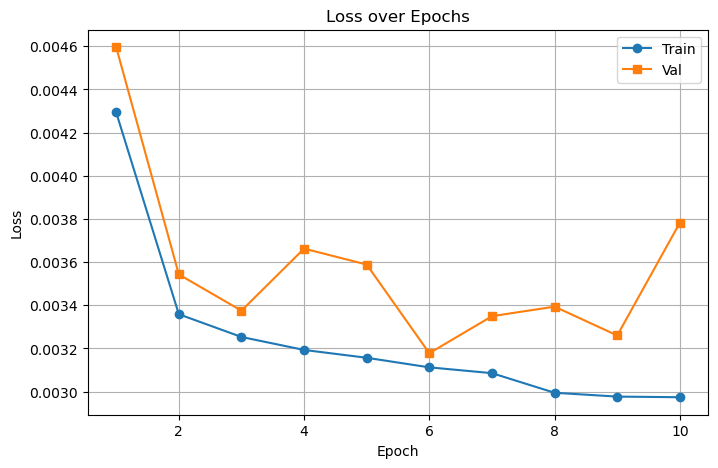

In [9]:
# Initialisieren des Trainingsprozess sowie aufrufen des Trainings und ausgabe der Durchgangsstatistik
trainer = Trainer(model = model, train_loader= train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, device=device, validate=True)
trainer.fit(num_epochs)

# 6. Lernkurve anzeigen
trainer.plot_history()

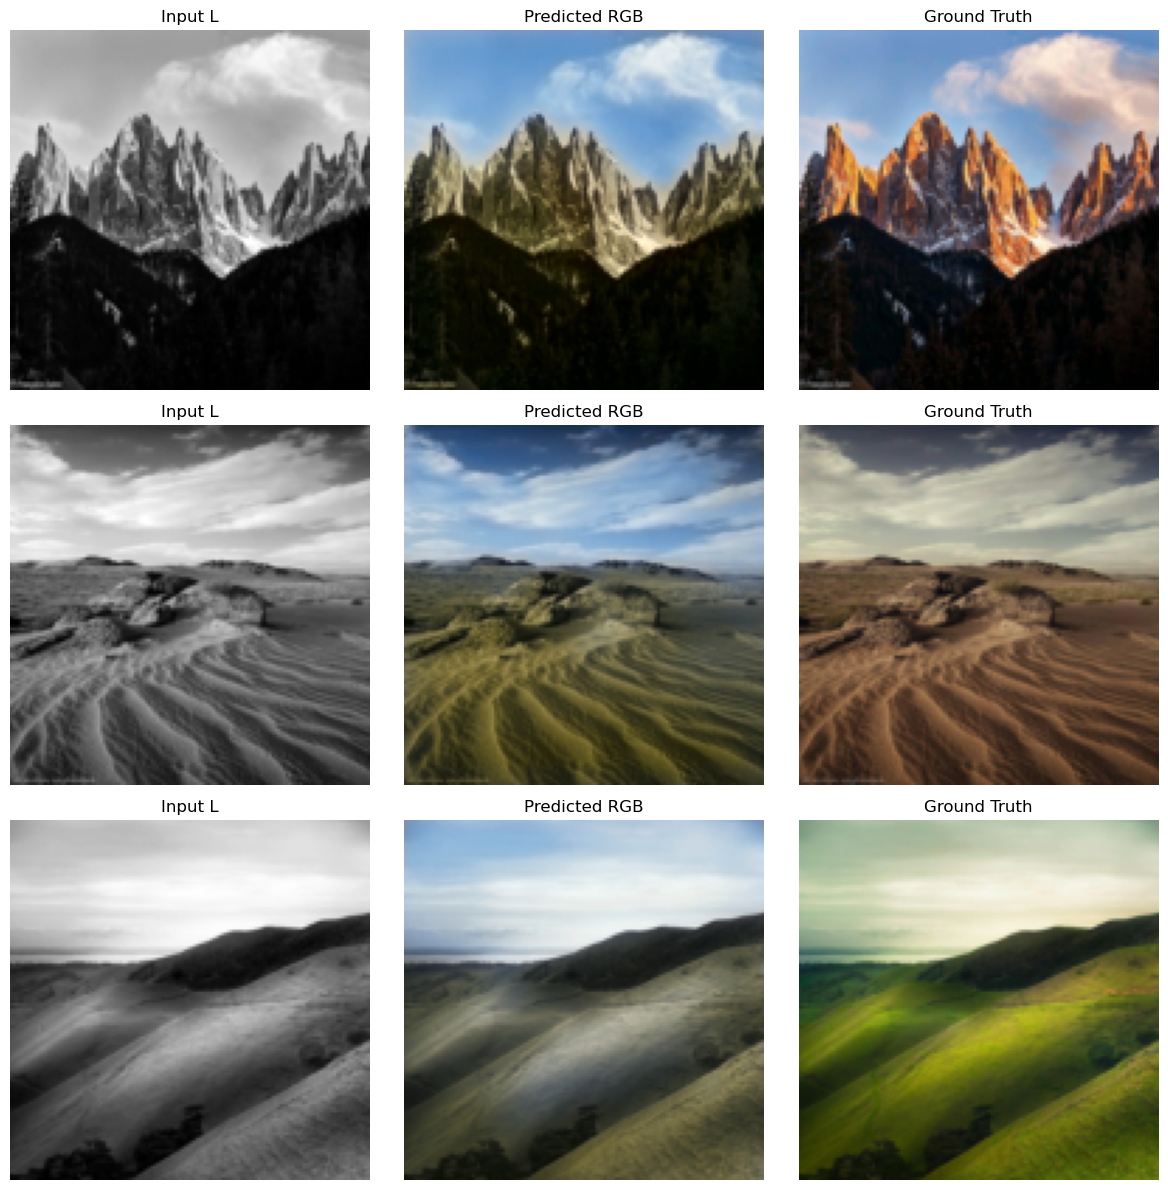

In [10]:
# Erste Visuelle Inspektion, hierfür wird der Testdatensatz verwendet
trainer.show_examples(test_loader)

In [11]:
# Bewertungskennzahlen zum evaluieren der Ergebnisse

psnr = evaluate_psnr(model, test_loader, device)
ssim = evaluate_ssim(model, test_loader, device)
ciede = evaluate_ciede2000(model, test_loader, device)
# PSNR > 40 dB: nahezu identisch // 30–40 dB: sehr gute Qualität // 20–30 dB: akzeptabel // < 20 dB: deutlich sichtbare Fehler
# ssim: 0 -> 1
# CIEDE2000: ΔE < 1 // 1,0 ≤ ΔE < 2,0 // 2,0 ≤ ΔE < 5,0 // ΔE ≥ 5,0
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"CIEDE2000: {ciede:.4f}")


PSNR: 21.76 dB
SSIM: 0.8734
CIEDE2000: 4.4843
